**Nome:** Pedro Henrique Silva Domingues

**R.A.:** 122.103-5

### Bibliotecas

In [1]:
import cv2 # OpenCV - Para carregar imagem do disco
import matplotlib.pyplot as plt # Para plot de grafico e exibir imagem
import numpy as np # Para operação em arrays
from functools import partial # Manipular funções
from sklearn.cluster import KMeans # Scikit learn - para usar os algoritmos de clusterização
from skimage import filters

### Constantes

In [2]:
IMG_PATH = './images/test_image.jpg' # Caminho da imagem que sera utilizada

### Funções auxiliares

In [11]:
# Mostra a imagem no notebook
def show_image(image, ax=None, rgb=False):
    cmap = None if rgb else 'gray'
    if ax is None:
        plt.figure()
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
    else:
        ax.imshow(image, cmap=cmap)
        ax.axis('off')

# Plota o histograma calculado previamente
def plot_histogram(hist, thresholds=[], ax=None, **kwargs):
    if ax is None:
        plt.figure()
        plotter = plt
    else:
        plotter = ax
    plotter.bar(range(256), hist, **kwargs)
    for n, threshold in enumerate(thresholds):
        c = plt.cm.get_cmap('Set1', len(thresholds))
        plotter.axvline(threshold, ls='--', c=c(n), label=f'threshold ({threshold})')
        plotter.legend()

# Cria o histograma da imagem
def histogram(image, density=False):
    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    return hist

def apply_threshold(img, thresholds, reversed=False):
    def get_color_idx(value, thresholds):
        for idx, threshold in enumerate(sorted(thresholds)):
            if value <= threshold:
                return idx
        return len(thresholds)
    colors = [int(i*255/len(thresholds)) for i in range(len(thresholds)+1)][::-1 if reversed else 1]
    img_copy = img.copy()
    func = lambda value: colors[get_color_idx(value, thresholds)]
    return np.vectorize(func)(img_copy).astype(np.uint8)

### Carregando dados

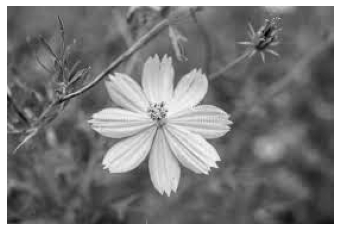

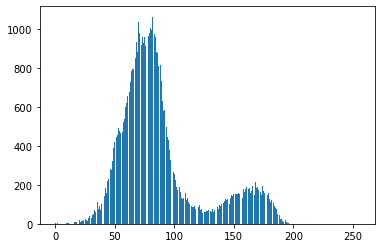

In [4]:
# Load the image
img = cv2.imread(IMG_PATH, 0)
img_histogram = histogram(img)
# Display the image
show_image(img)
# Plot the histogram
plot_histogram(img_histogram)

---

### 1. Equalizando imagem

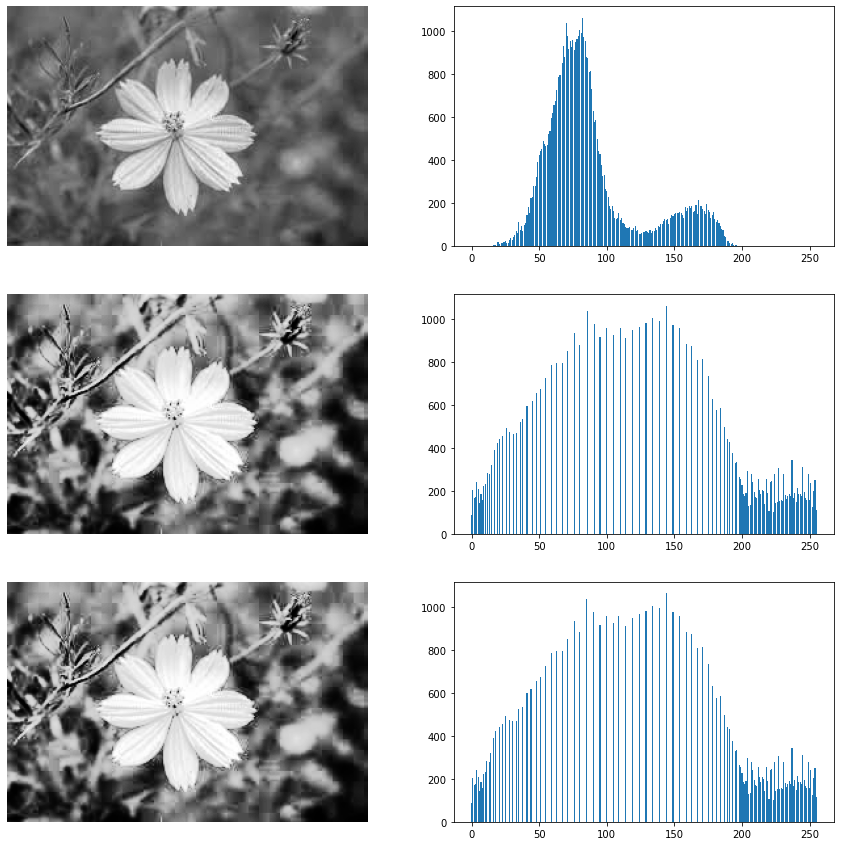

In [5]:
img2 = cv2.equalizeHist(img)
img3 = cv2.equalizeHist(img2)

fig, ax = plt.subplots(3,2, figsize=(15,15))

show_image(img,  ax=ax[0][0])
show_image(img2, ax=ax[1][0])
show_image(img3, ax=ax[2][0])

plot_histogram(histogram(img),  ax=ax[0][1])
plot_histogram(histogram(img2), ax=ax[1][1])
plot_histogram(histogram(img3), ax=ax[2][1])

---

### 2

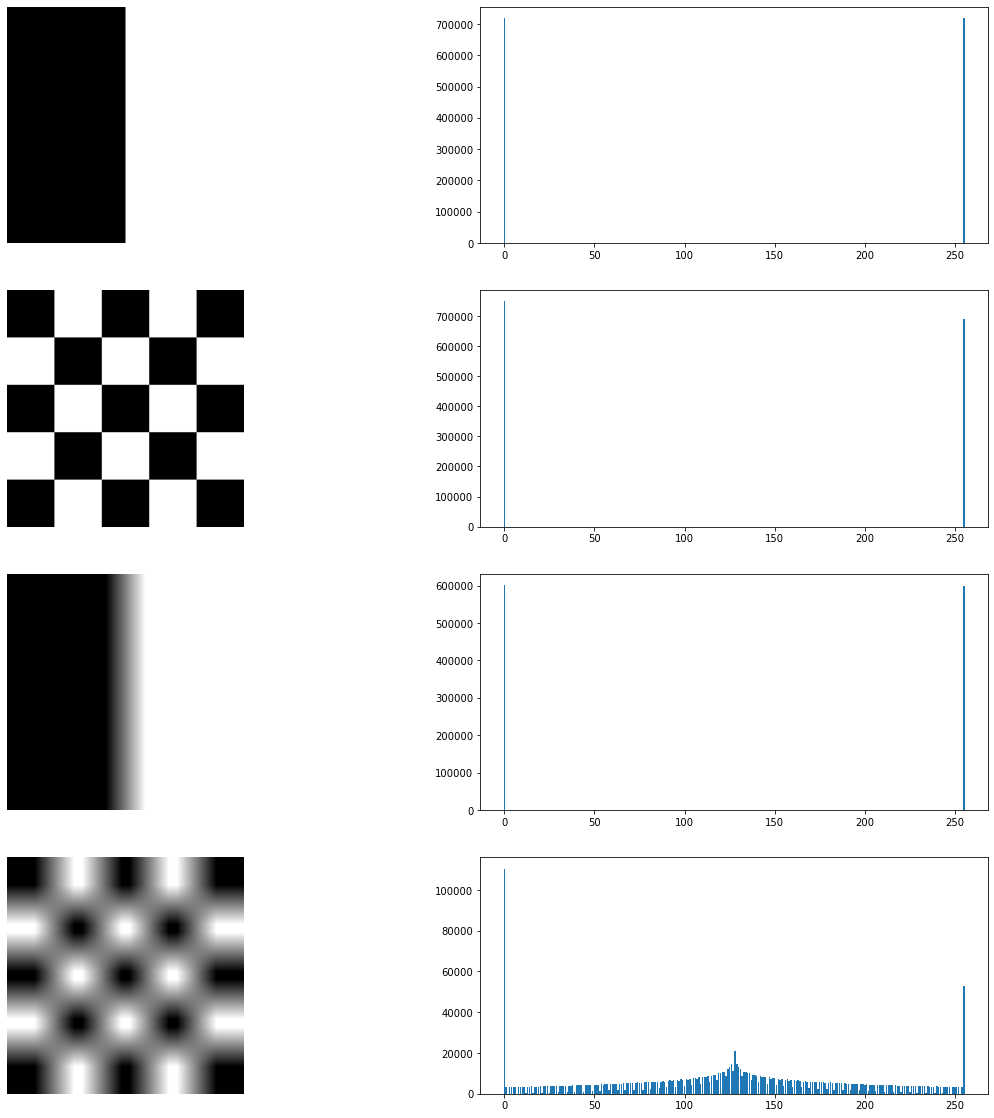

In [48]:
WIDTH = 1200
HEIGHT = 1200

fig, ax = plt.subplots(4,2, figsize=(20,20))

# Half Half
img1 = np.zeros((WIDTH, HEIGHT))
for i in range(HEIGHT):
    for j in range(WIDTH):
        img1[i][j] = 0 if j < WIDTH / 2 else 255
show_image(img1, ax=ax[0][0])
plot_histogram(histogram(img1), ax=ax[0][1])

# Checkboard
# img2 = np.zeros((WIDTH,HEIGHT))
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         if (i+j)%4:
#             img2[i][j] = 255
img2 = cv2.imread("images/checkerboard.png",0)
show_image(img2, ax=ax[1][0])
plot_histogram(histogram(img2), ax=ax[1][1])

# Filtro de media
blured_img1 = cv2.blur(img1,(200,200))
blured_img2 = cv2.blur(img2,(200,200))
show_image(blured_img1, ax=ax[2][0])
plot_histogram(histogram(blured_img1), ax=ax[2][1])
show_image(blured_img2, ax=ax[3][0])
plot_histogram(histogram(blured_img2), ax=ax[3][1])


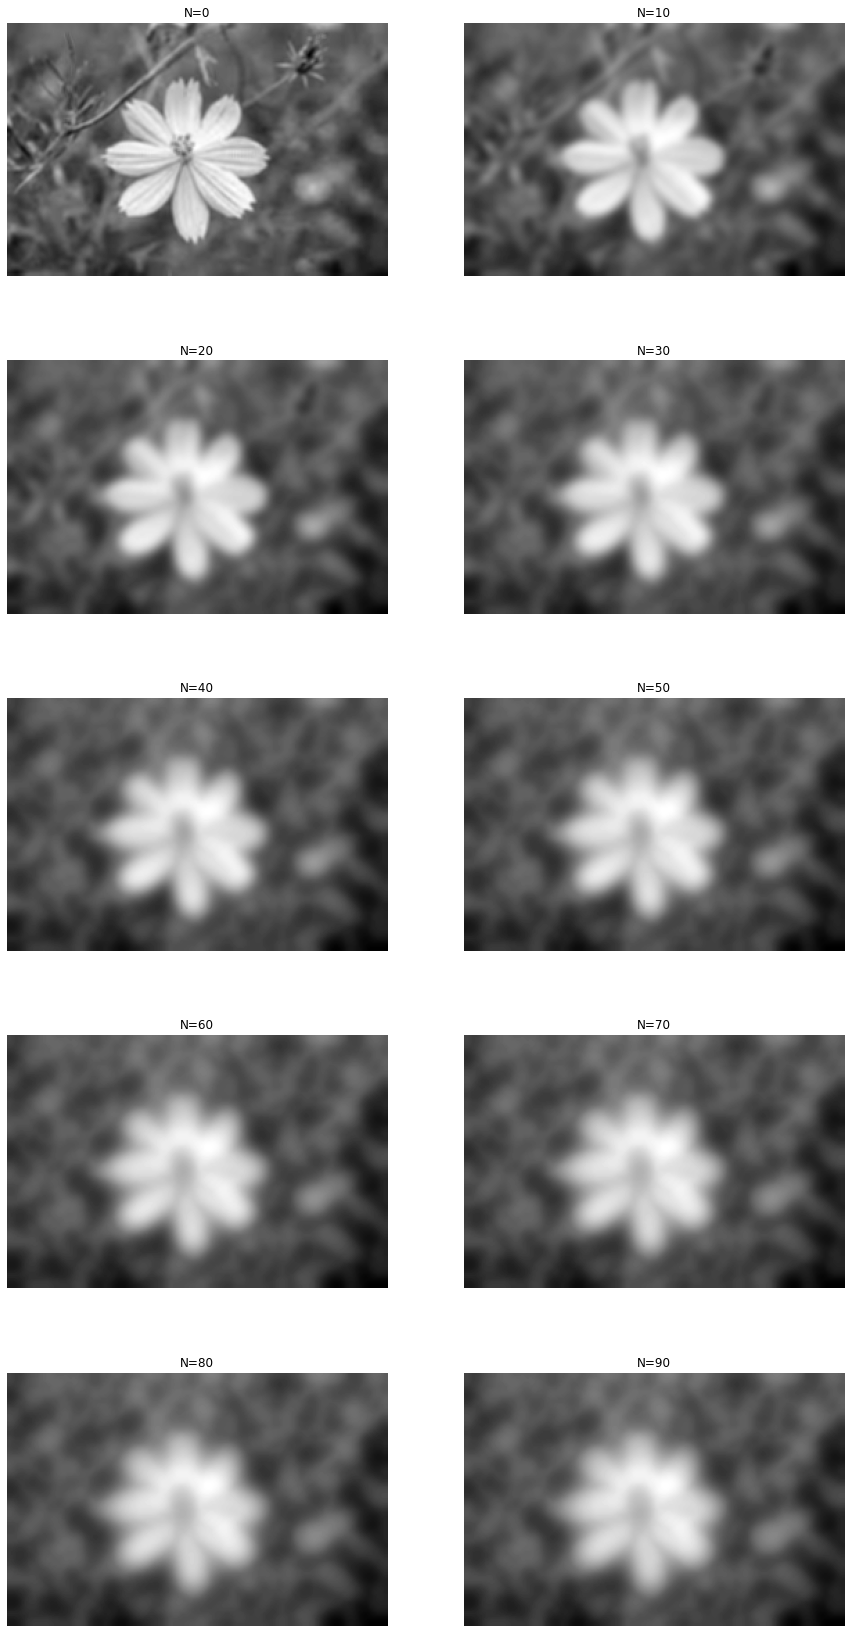

In [7]:
# Create a 3x3 Kernel
kernel = np.ones((3,3), np.float32)/9
# Checkpoints
def get_next_pos(lines, cols):
    for i in range(lines):
        for j in range(cols):
            yield (i,j)
checkpoints = [i*10 for i in range(10)]
idx = get_next_pos(5,2)
# Plot
fig, ax = plt.subplots(5,2, figsize=(15,30))
# Apply convolution between image and 3x3 Kernel
result = img.copy()
for iteration in range(200):
    result = cv2.filter2D(result,-1, kernel)
    if iteration in checkpoints:
        i, j = next(idx)
        ax[i][j].set_title(f'N={iteration}')
        show_image(result, ax=ax[i][j])

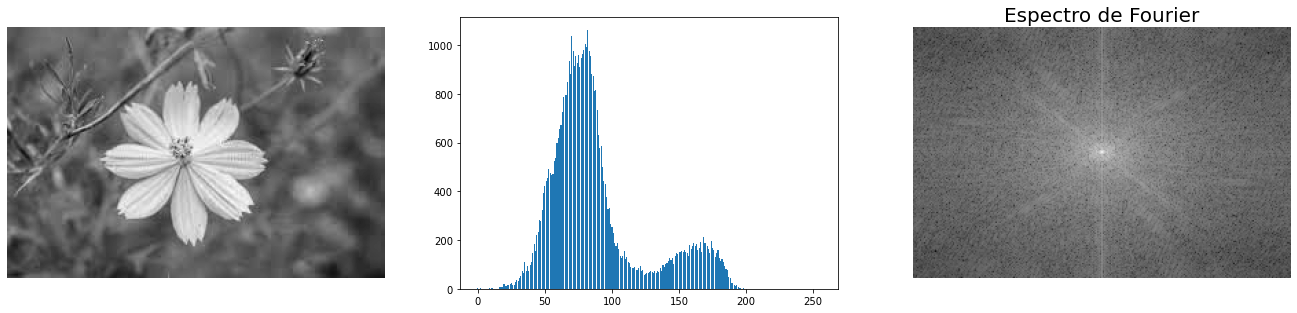

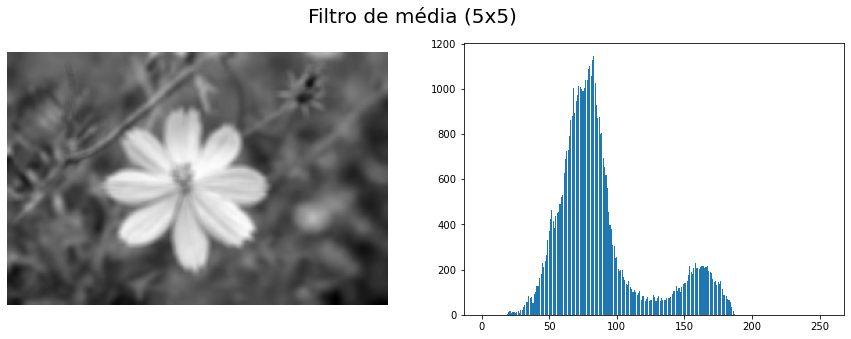

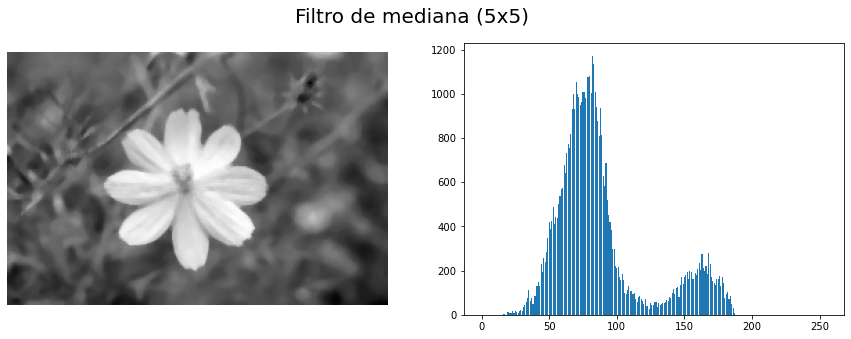

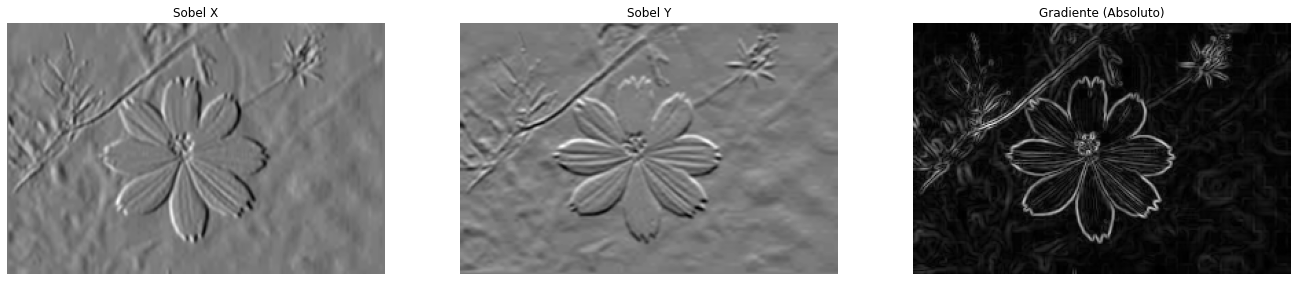

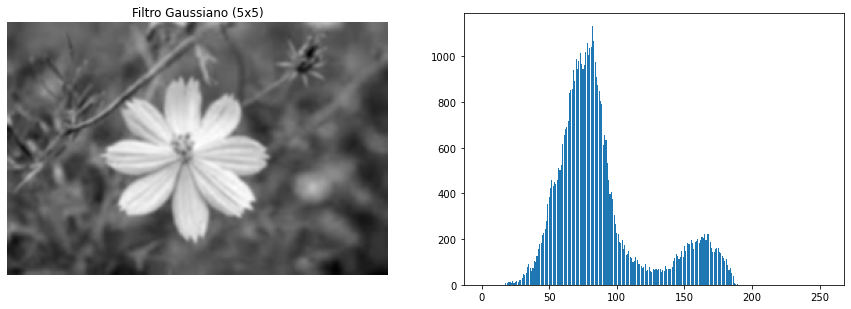

In [29]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

# Espectro de fourier
fig, ax = plt.subplots(1,3, figsize=(23,5))
ax[2].set_title('Espectro de Fourier', fontsize=20)
show_image(img, ax[0])
plot_histogram(histogram(img), ax=ax[1])
show_image(magnitude_spectrum, ax[2])

# fshift[len(img)-5000:len(img)+5000, len(img[0])-5000:len(img[0])+5000] = 0
# f_ishift= np.fft.ifftshift(img - fshift).astype(float)
# show_image(f_ishift)

# Filtro de media
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Filtro de média (5x5)', fontsize=20)
blured_img = cv2.blur(img,(5,5))
show_image(blured_img, ax[0])
plot_histogram(histogram(blured_img), ax=ax[1])

# Filtro de mediana
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Filtro de mediana (5x5)', fontsize=20)
blured_img = cv2.medianBlur(img,5)
show_image(blured_img, ax[0])
plot_histogram(histogram(blured_img), ax=ax[1])

# Filtro de Sobel
fig, ax = plt.subplots(1,3, figsize=(23,5))
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y
edges = filters.sobel(img)
abs_sobel= np.absolute(edges)
show_image(sobelx, ax=ax[0]); ax[0].set_title("Sobel X")
show_image(sobely, ax=ax[1]); ax[1].set_title("Sobel Y")
show_image(abs_sobel, ax=ax[2]); ax[2].set_title("Gradiente (Absoluto)")

# Filtro Gaussiano
fig, ax = plt.subplots(1,2, figsize=(15,5))
blured_img = cv2.GaussianBlur(img,(5,5),0)
show_image(blured_img, ax=ax[0]); ax[0].set_title("Filtro Gaussiano (5x5)")
plot_histogram(histogram(blured_img), ax=ax[1])

---

## 8

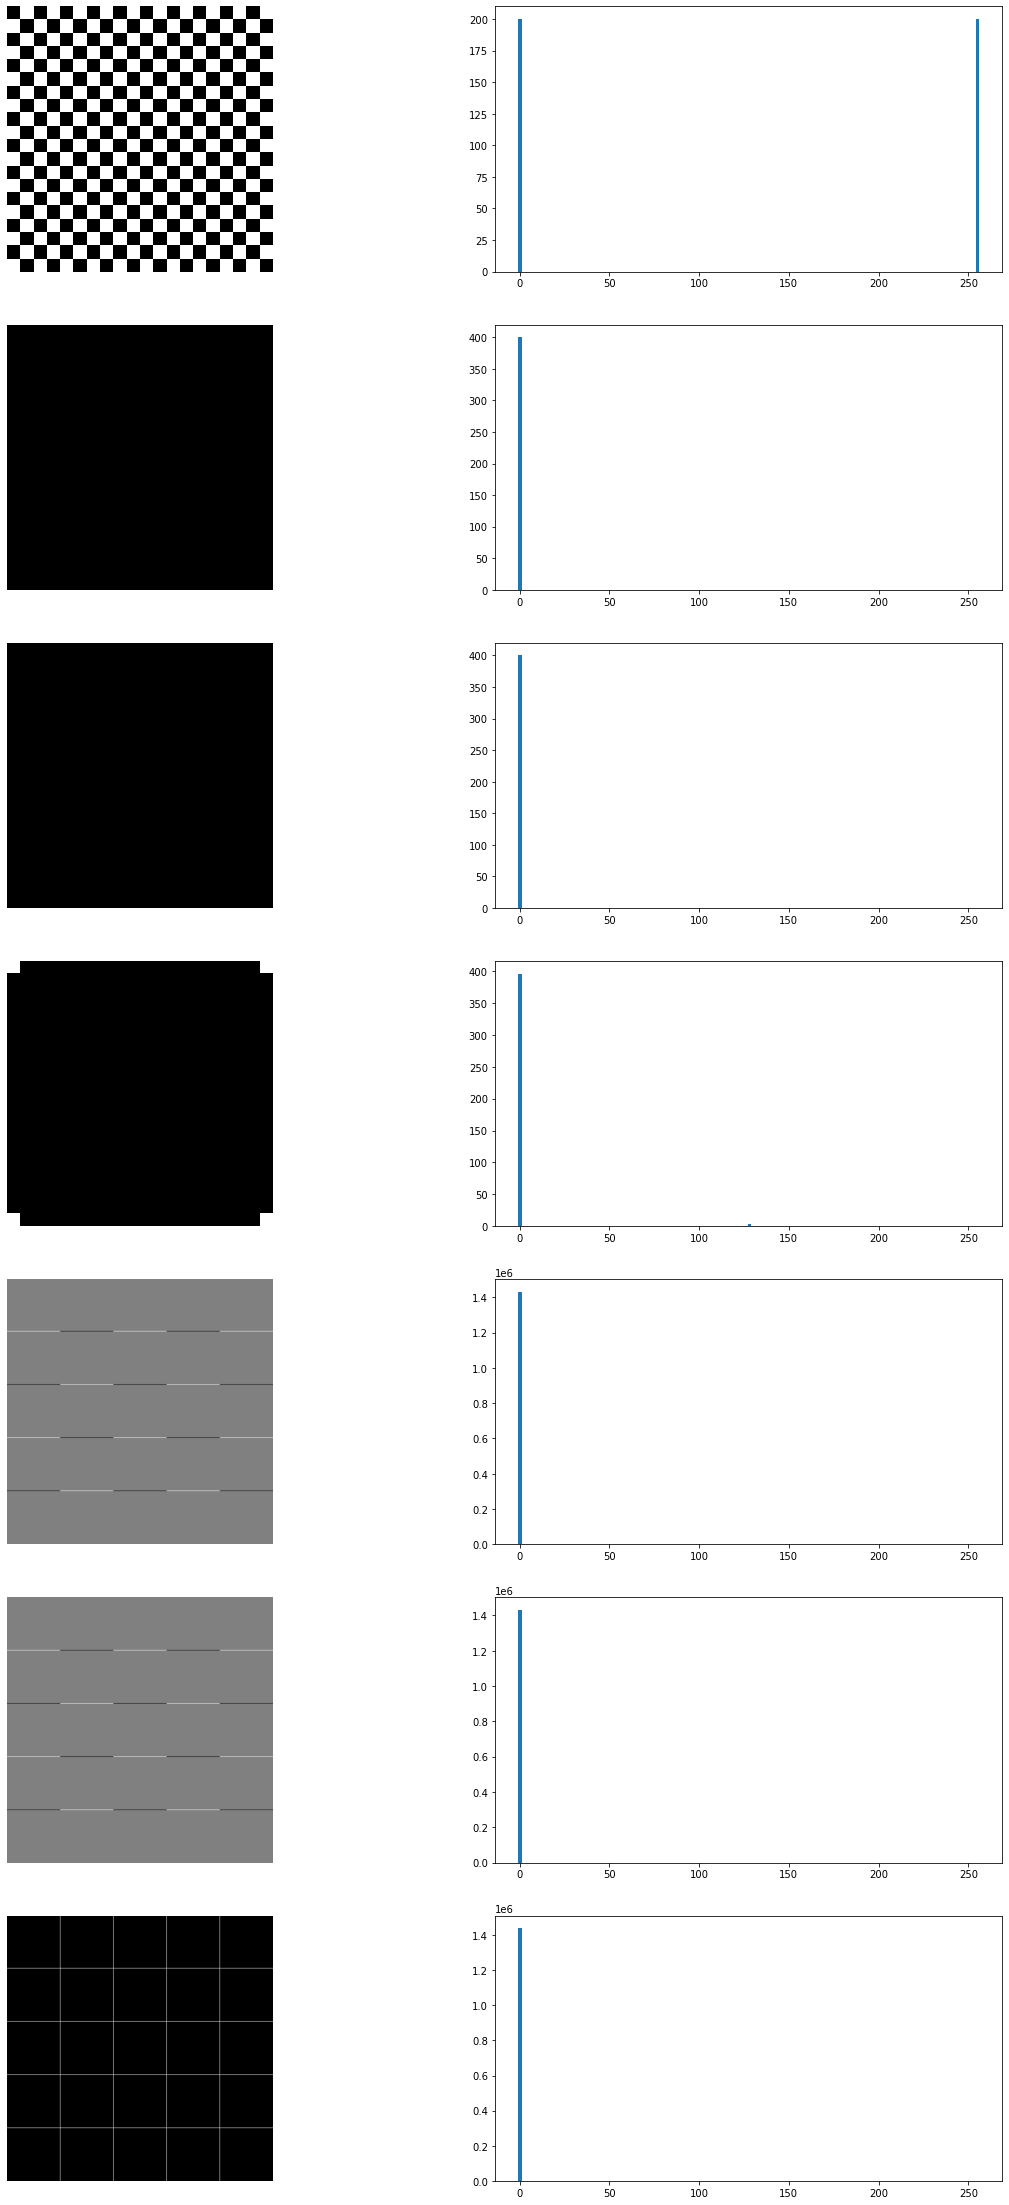

In [13]:
img = np.zeros((20,20))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if (i+j)%2:
            img[i][j] = 255

sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)  # y
edges = filters.sobel(img)
abs_sobel= np.absolute(edges)

# Big checkboard
c = cv2.imread("images/checkerboard.png",0)
c_sbx = cv2.Sobel(c,cv2.CV_64F,0,1,ksize=3)
c_sby = cv2.Sobel(c,cv2.CV_64F,0,1,ksize=3)
c_sba = np.absolute(filters.sobel(c))

fig, ax = plt.subplots(7,2, figsize=(20,40))
show_image(img, ax=ax[0][0]); plot_histogram(histogram(img), ax=ax[0][1], width=2)
show_image(sobelx, ax=ax[1][0]); plot_histogram(histogram(sobelx), ax=ax[1][1], width=2)
show_image(sobely, ax=ax[2][0]); plot_histogram(histogram(sobely), ax=ax[2][1], width=2)
show_image(abs_sobel, ax=ax[3][0]); plot_histogram(histogram(abs_sobel), ax=ax[3][1], width=2)
show_image(c_sbx, ax=ax[4][0]); plot_histogram(histogram(c_sbx), ax=ax[4][1], width=2)
show_image(c_sby, ax=ax[5][0]); plot_histogram(histogram(c_sby), ax=ax[5][1], width=2)
show_image(c_sba, ax=ax[6][0]); plot_histogram(histogram(c_sba), ax=ax[6][1], width=2)

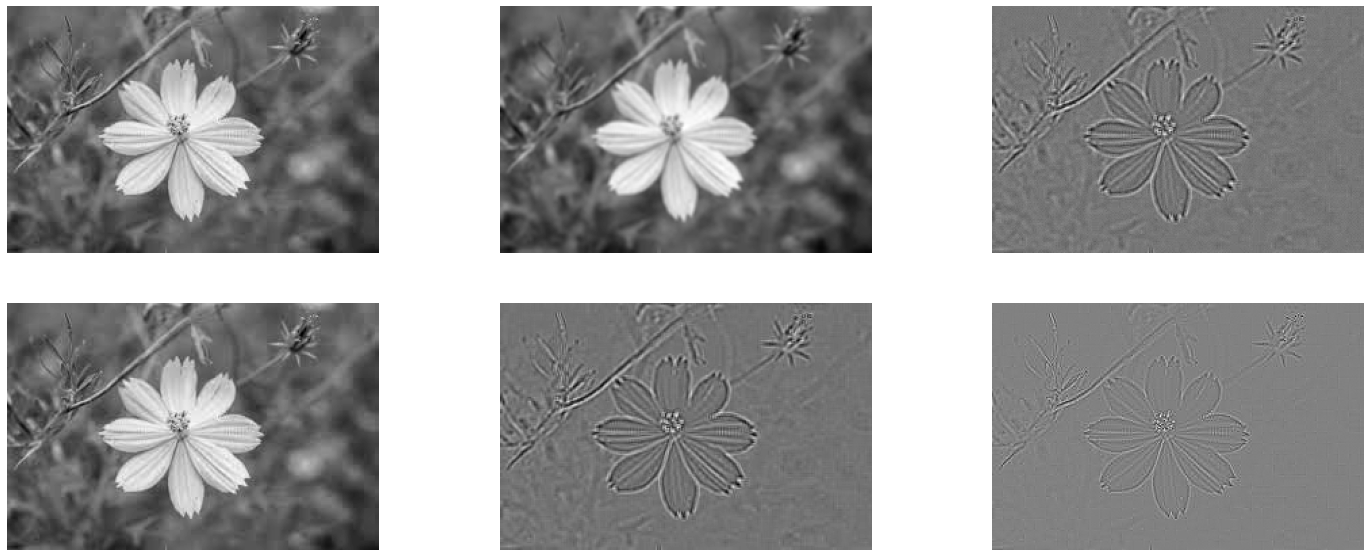

In [26]:
img = cv2.imread('images/test_image.jpg', 0)

fig, ax = plt.subplots(2,3, figsize=(25,10))

blured_img = cv2.blur(img,(3,3))
laplacian_img = cv2.Laplacian(blured_img,cv2.CV_64F)
show_image(img, ax=ax[0][0])
show_image(blured_img, ax=ax[0][1])
show_image(laplacian_img, ax=ax[0][2])

laplacian_img = cv2.Laplacian(img,cv2.CV_64F)
blured_img = cv2.blur(laplacian_img,(3,3))
show_image(img, ax=ax[1][0])
show_image(blured_img, ax=ax[1][1])
show_image(laplacian_img, ax=ax[1][2])